<a href="https://colab.research.google.com/github/HitarthSheth/capstone/blob/main/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import zipfile
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from google.colab import drive

# TensorFlow and Keras libraries for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping the PD Marked images
zip_file_path = '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Marked - PD/Hospital/PD_Marked (2).zip'
extract_path = '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Marked - PD/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Load the PD marked DataFrame with the correct header row
pd_marked_df = pd.read_csv('/content/PD_Marked_DS.csv', header=1)

# Load the non-PD marked DataFrame with the correct header row
non_pd_marked_df = pd.read_csv('/content/Non_PD_Marked.csv', header=1)

# Clean up the column names
pd_marked_df.columns = ['Subject', 'Midbrain_Area', 'P', 'Pons_Area', 'P', 'Ratio']
non_pd_marked_df.columns = ['Subject', 'Midbrain_Area', 'P', 'Pons_Area', 'P', 'Ratio']

In [ ]:
# Print DataFrame columns for debugging
print("PD Marked DataFrame Columns:", pd_marked_df.columns)
print("Non-PD Marked DataFrame Columns:", non_pd_marked_df.columns)

PD Marked DataFrame Columns: Index(['Subject', 'Midbrain_Area', 'P', 'Pons_Area', 'P', 'Ratio'], dtype='object')
Non-PD Marked DataFrame Columns: Index(['Subject', 'Midbrain_Area', 'P', 'Pons_Area', 'P', 'Ratio'], dtype='object')


In [ ]:
# Set image dimensions
image_height = 224
image_width = 224

# Function to load images and calculate features
def create_dataset(image_folder, df, label):
    images = []
    features = []
    labels = []

    for index, row in df.iterrows():
        img_name = f"{row['Subject']}.jpg"
        img_path = os.path.join(image_folder, img_name)

        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            img = img.resize((image_height, image_width))
            img_array = np.array(img) / 255.0
            ratio = row['Midbrain_Area'] / row['Pons_Area']

            # Determine label based on threshold and add only if conditions are met
            if label == 'PD' and 0.10 <= ratio <= 0.41:
                images.append(img_array)
                features.append([row['Midbrain_Area'], row['Pons_Area'], ratio])
                labels.append(1)  # PD label
                print(f"Image {img_name}: PD label assigned. Ratio: {ratio}")
            elif label == 'Non-PD' and ratio > 0.41:
                images.append(img_array)
                features.append([row['Midbrain_Area'], row['Pons_Area'], ratio])
                labels.append(0)  # Non-PD label
                print(f"Image {img_name}: Non-PD label assigned. Ratio: {ratio}")
            else:
                print(f"Ratio {ratio} for {img_name} does not meet expected thresholds.")
        else:
            print(f"Image not found: {img_path}")

    return np.array(images), np.array(features), np.array(labels)

# Load PD and Non-PD images and features
pd_marked_images, pd_marked_features, pd_labels = create_dataset(
    '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Marked - PD/PD_Marked',
    pd_marked_df,
    label='PD'
)

healthy_marked_images, healthy_marked_features, healthy_labels = create_dataset(
    '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Marked - Healthy',
    non_pd_marked_df,
    label='Non-PD'
)

print("PD and Healthy Marked Datasets Loaded Successfully")

Image PD_Marked_000.jpg: PD label assigned. Ratio: 0.2618968386023295
Image PD_Marked_001.jpg: PD label assigned. Ratio: 0.15156650246305417
Image PD_Marked_002.jpg: PD label assigned. Ratio: 0.19595170454545455
Image PD_Marked_003.jpg: PD label assigned. Ratio: 0.19605459586265728
Image PD_Marked_004.jpg: PD label assigned. Ratio: 0.23561417971970322
Image PD_Marked_005.jpg: PD label assigned. Ratio: 0.24120103400278387
Image PD_Marked_006.jpg: PD label assigned. Ratio: 0.22849712056474084
Image PD_Marked_007.jpg: PD label assigned. Ratio: 0.3472560404570144
Image PD_Marked_008.jpg: PD label assigned. Ratio: 0.39689847346740975
Image PD_Marked_009.jpg: PD label assigned. Ratio: 0.29406969635215
Image PD_Marked_010.jpg: PD label assigned. Ratio: 0.3007531380753138
Image PD_Marked_011.jpg: PD label assigned. Ratio: 0.17316790352504638
Image PD_Marked_012.jpg: PD label assigned. Ratio: 0.19254433586681147
Image PD_Marked_013.jpg: PD label assigned. Ratio: 0.22004469657899262
Image PD_Mar

In [ ]:
# Combine the datasets and labels
X = np.concatenate((pd_marked_images, healthy_marked_images), axis=0)
y = np.concatenate((pd_labels, healthy_labels), axis=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Instantiate and train the model
model = create_model()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5274 - loss: 0.5160 - val_accuracy: 0.9474 - val_loss: 0.2179
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9826 - loss: 0.1132 - val_accuracy: 0.9474 - val_loss: 0.1697
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9630 - loss: 0.2047 - val_accuracy: 0.9474 - val_loss: 0.1546
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9630 - loss: 0.0891 - val_accuracy: 0.9474 - val_loss: 0.3401
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9709 - loss: 0.1543 - val_accuracy: 0.9474 - val_loss: 0.2081
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9709 - loss: 0.0506 - val_accuracy: 0.9474 - val_loss: 0.1182
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9630 - loss: 0.0466 - val_accuracy: 0.9474 - val_loss: 0.1003
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.9474 - val_loss: 0.1262
Epoch 9/20

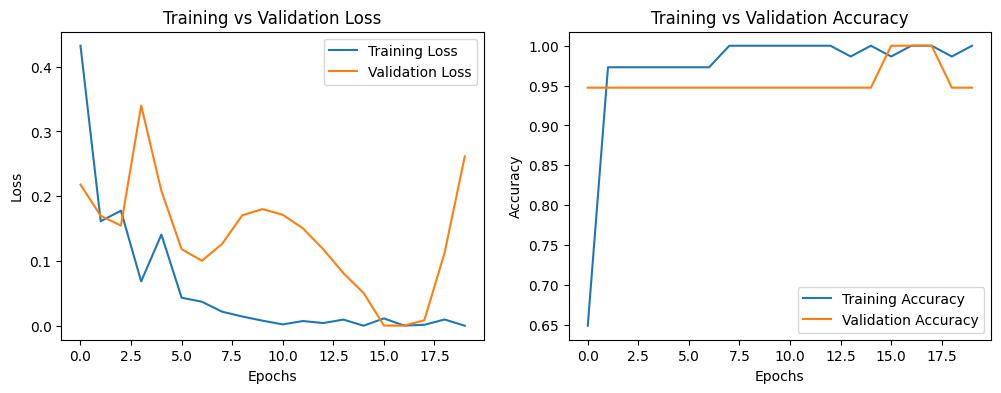

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Predictions and evaluation
y_pred_probs = model.predict(X_val).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 755ms/step

Confusion Matrix (Complete Dataset):
True Negatives: 2
False Positives: 1
False Negatives: 0
True Positives: 90

Overall Metrics:
Accuracy: 0.9892
Precision: 0.9890
Recall: 1.0000
F1 Score: 0.9945


<Figure size 1000x800 with 0 Axes>

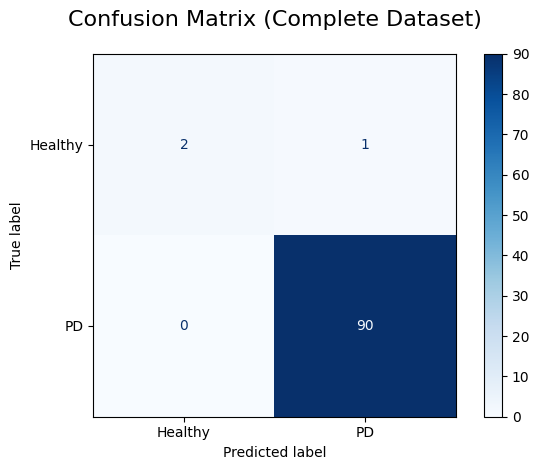

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Get predictions for all data
y_pred_probs = model.predict(X)  # These are probability predictions
# Convert probabilities to binary predictions using threshold of 0.5
y_pred_all = (y_pred_probs >= 0.5).astype(int)
y_true_all = y

# Generate confusion matrix for all data
cm_all = confusion_matrix(y_true_all, y_pred_all)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_all,
    display_labels=['Healthy', 'PD']
)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Complete Dataset)', fontsize=16, pad=20)
plt.tight_layout()

# Print detailed metrics
print("\nConfusion Matrix (Complete Dataset):")
print(f"True Negatives: {cm_all[0,0]}")
print(f"False Positives: {cm_all[0,1]}")
print(f"False Negatives: {cm_all[1,0]}")
print(f"True Positives: {cm_all[1,1]}")

# Calculate metrics # This is the fix!!!
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all)
recall = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 782ms/step

AUC Score: 1.0000


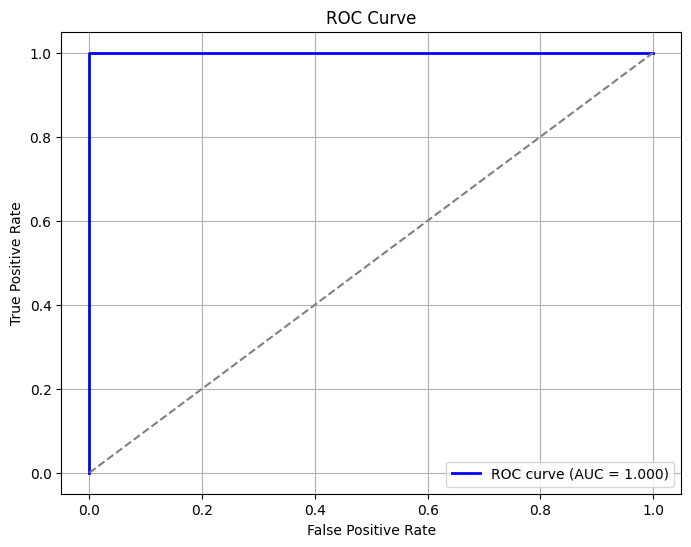

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions for all data
y_pred_proba = model.predict(X)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Print AUC score
print(f"\nAUC Score: {roc_auc:.4f}")

plt.show()


Classification Metrics:
Accuracy: 0.8276
Precision: 0.8571
Recall: 0.8000
F1 Score: 0.8276


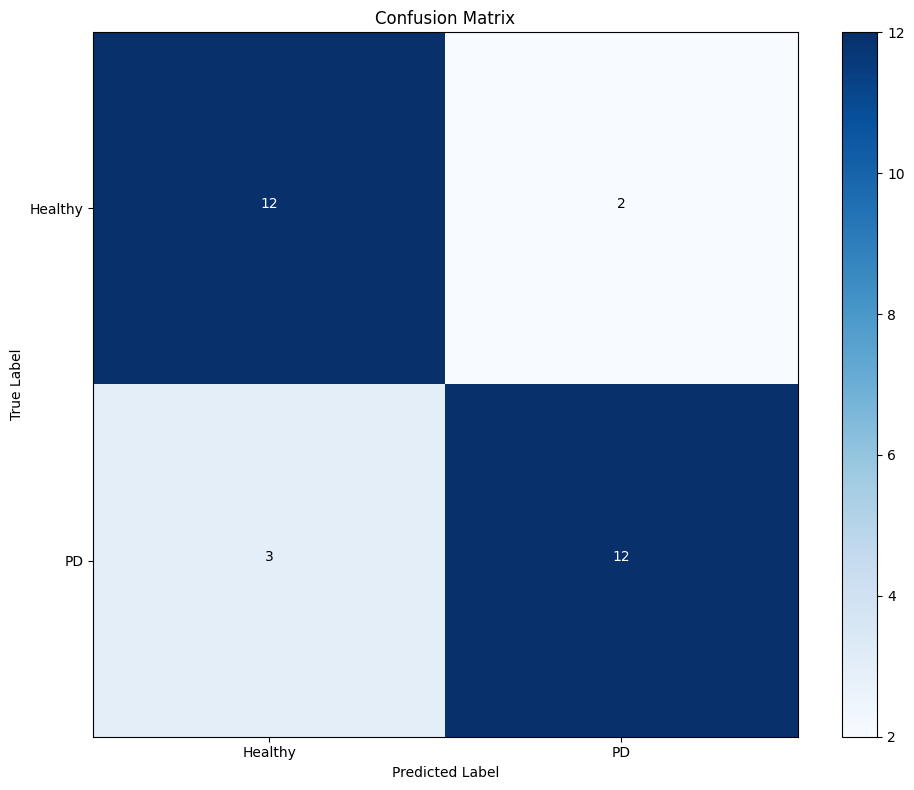


Detailed Results:
               File Predicted  Actual
  CD-P11-A00001.jpg   Healthy Healthy
  CD-P01-A00001.jpg   Healthy Healthy
  CD-P10-A00001.jpg   Healthy Healthy
  CD-P04-A00001.jpg   Healthy Healthy
  CD-P03-A00001.jpg   Healthy Healthy
  CD-P02-A00001.jpg   Healthy Healthy
  CD-P09-A00001.jpg   Healthy Healthy
  CD-P08-A00001.jpg        PD Healthy
  CD-P06-A00001.jpg   Healthy Healthy
  CD-P05-A00001.jpg   Healthy Healthy
  CD-P07-A00001.jpg   Healthy Healthy
  CD-P13-A00001.jpg        PD Healthy
  CD-P23-A00001.jpg   Healthy Healthy
  CD-P12-A00001.jpg   Healthy Healthy
PD_UnMarked_076.jpg        PD      PD
PD_UnMarked_072.jpg        PD      PD
PD_UnMarked_057.jpg        PD      PD
PD_UnMarked_068.jpg        PD      PD
PD_UnMarked_051.jpg        PD      PD
PD_UnMarked_041.jpg        PD      PD
PD_UnMarked_025.jpg        PD      PD
PD_UnMarked_024.jpg   Healthy      PD
PD_UnMarked_013.jpg   Healthy      PD
PD_UnMarked_023.jpg        PD      PD
PD_UnMarked_038.jpg        PD  

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

def load_and_preprocess_image(image_path):
    """
    Load and preprocess a single image for prediction
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))  # Match the training dimensions
        img_array = np.array(img) / 255.0  # Normalize
        return np.expand_dims(img_array, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def predict_folder(model, folder_path, expected_label=None):
    """
    Process all images in a folder and return predictions and metrics
    """
    predictions = []
    file_names = []
    true_labels = []

    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)
            processed_img = load_and_preprocess_image(img_path)

            if processed_img is not None:
                # Get prediction
                pred_prob = model.predict(processed_img, verbose=0)[0][0]
                pred_label = 1 if pred_prob >= 0.5 else 0

                predictions.append(pred_label)
                file_names.append(img_name)
                if expected_label is not None:
                    true_labels.append(expected_label)

    return predictions, file_names, true_labels

def evaluate_model(healthy_folder, pd_folder, model):
    """
    Evaluate model performance on both healthy and PD images
    """
    # Process healthy images
    healthy_preds, healthy_files, healthy_labels = predict_folder(model, healthy_folder, expected_label=0)

    # Process PD images
    pd_preds, pd_files, pd_labels = predict_folder(model, pd_folder, expected_label=1)

    # Combine predictions and true labels
    all_preds = healthy_preds + pd_preds
    all_files = healthy_files + pd_files
    all_true = healthy_labels + pd_labels

    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds)
    recall = recall_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds)
    cm = confusion_matrix(all_true, all_preds)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'File': all_files,
        'Predicted': ['PD' if p == 1 else 'Healthy' for p in all_preds],
        'Actual': ['PD' if t == 1 else 'Healthy' for t in all_true]
    })

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'results_df': results_df
    }

def plot_results(metrics):
    """
    Plot confusion matrix and print metrics
    """
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = metrics['confusion_matrix']
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Healthy', 'PD']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Print metrics
    print("\nClassification Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    plt.show()

    # Display detailed results
    print("\nDetailed Results:")
    print(metrics['results_df'].to_string(index=False))

# Save the model
model.save('pd_classifier_Custom_CNN_model.h5')

# Main execution
healthy_folder = '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Test_UnMarked/Healthy'
pd_folder = '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Test_UnMarked/PD'

# Load the saved model
loaded_model = tf.keras.models.load_model('pd_classifier_Custom_CNN_model.h5')

# Evaluate the model on the raw images
metrics = evaluate_model(healthy_folder, pd_folder, loaded_model)

# Plot and display results
plot_results(metrics)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Classification Metrics:
Accuracy: 0.7931
Precision: 0.8710
Recall: 0.8710
F1 Score: 0.8710


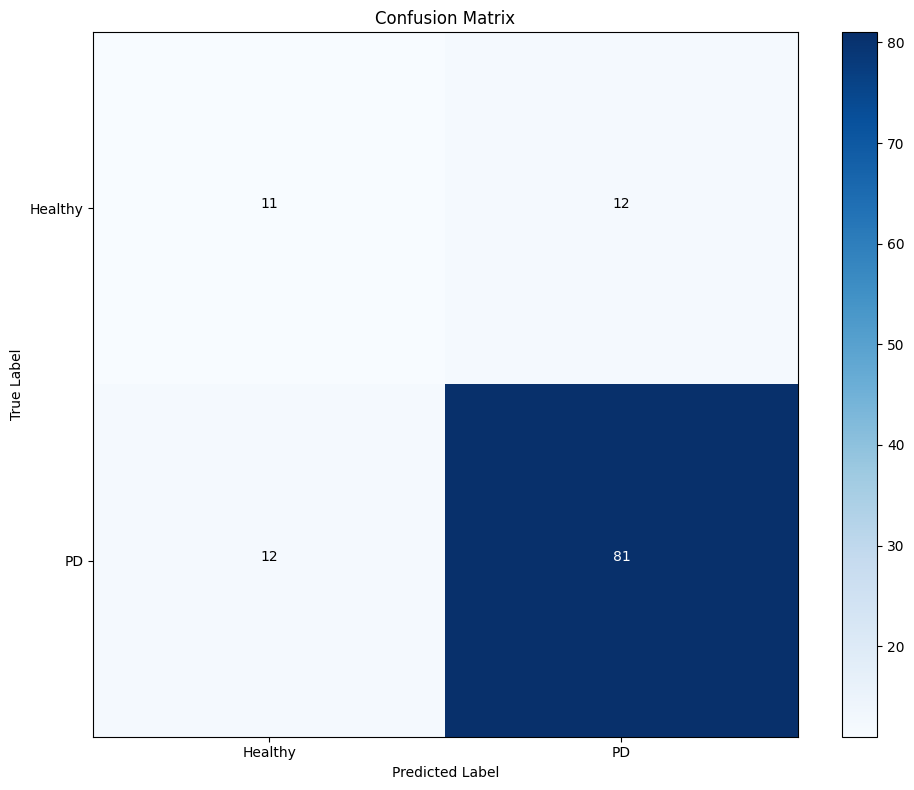


Detailed Results:
               File Predicted  Actual
  CD-P01-A00001.jpg        PD Healthy
  CD-P02-A00001.jpg        PD Healthy
  CD-P03-A00001.jpg        PD Healthy
  CD-P04-A00001.jpg        PD Healthy
  CD-P05-A00001.jpg        PD Healthy
  CD-P06-A00001.jpg        PD Healthy
  CD-P07-A00001.jpg        PD Healthy
  CD-P08-A00001.jpg   Healthy Healthy
  CD-P09-A00001.jpg        PD Healthy
  CD-P10-A00001.jpg        PD Healthy
  CD-P11-A00001.jpg        PD Healthy
  CD-P12-A00001.jpg        PD Healthy
  CD-P13-A00001.jpg   Healthy Healthy
  CD-P14-A00001.jpg   Healthy Healthy
  CD-P15-A00001.jpg   Healthy Healthy
  CD-P16-A00001.jpg   Healthy Healthy
  CD-P17-A00001.jpg   Healthy Healthy
  CD-P18-A00001.jpg   Healthy Healthy
  CD-P19-A00001.jpg   Healthy Healthy
  CD-P20-A00001.jpg   Healthy Healthy
  CD-P21-A00001.jpg   Healthy Healthy
  CD-P22-A00001.jpg   Healthy Healthy
  CD-P23-A00001.jpg        PD Healthy
PD_UnMarked_001.jpg        PD      PD
PD_UnMarked_002.jpg        PD  

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

def load_and_preprocess_image(image_path):
    """
    Load and preprocess a single image for prediction
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))  # Match the training dimensions
        img_array = np.array(img) / 255.0  # Normalize
        return np.expand_dims(img_array, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def predict_folder(model, folder_path, expected_label=None):
    """
    Process all images in a folder and return predictions and metrics
    """
    predictions = []
    file_names = []
    true_labels = []

    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)
            processed_img = load_and_preprocess_image(img_path)

            if processed_img is not None:
                # Get prediction
                pred_prob = model.predict(processed_img, verbose=0)[0][0]
                pred_label = 0 if pred_prob >= 0.5 else 1

                predictions.append(pred_label)
                file_names.append(img_name)
                if expected_label is not None:
                    true_labels.append(expected_label)

    return predictions, file_names, true_labels

def evaluate_model(healthy_folder, pd_folder, model):
    """
    Evaluate model performance on both healthy and PD images
    """
    # Process healthy images
    healthy_preds, healthy_files, healthy_labels = predict_folder(model, healthy_folder, expected_label=0)

    # Process PD images
    pd_preds, pd_files, pd_labels = predict_folder(model, pd_folder, expected_label=1)

    # Combine predictions and true labels
    all_preds = healthy_preds + pd_preds
    all_files = healthy_files + pd_files
    all_true = healthy_labels + pd_labels

    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds)
    recall = recall_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds)
    cm = confusion_matrix(all_true, all_preds)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'File': all_files,
        'Predicted': ['PD' if p == 1 else 'Healthy' for p in all_preds],
        'Actual': ['PD' if t == 1 else 'Healthy' for t in all_true]
    })

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'results_df': results_df
    }

def plot_results(metrics):
    """
    Plot confusion matrix and print metrics
    """
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = metrics['confusion_matrix']
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Healthy', 'PD']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Print metrics
    print("\nClassification Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    plt.show()

    # Display detailed results
    print("\nDetailed Results:")
    print(metrics['results_df'].to_string(index=False))

# Save the model
model.save('pd_classifier_Custom_CNN_model.h5')

# Main execution
healthy_folder = '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Raw - Healthy'
pd_folder = '/content/drive/MyDrive/Capstone/Semester 7 Capstone Project/02 - Database/Hospital/Raw - PD/PD_RAW'

# Load the saved model
loaded_model = tf.keras.models.load_model('pd_classifier_Custom_CNN_model.h5')

# Evaluate the model on the raw images
metrics = evaluate_model(healthy_folder, pd_folder, loaded_model)

# Plot and display results
plot_results(metrics)